<a href="https://colab.research.google.com/github/mateuszkasprowicz/graph_representation_learning_workshops/blob/master/02_graph_kernels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph kernels

## Setup

Install libraries:
- standard data science stack (Numpy, Pandas, Scikit-learn)
- graph and graph kernels libraries (NetworkX, GraKeL)


In [ ]:
!pip install numpy pandas scikit-learn grakel

## Data loading

We will use **PROTEINS** dataset:
- bioinformatics proteins dataset
- each graph represents a protein: enzyme or non-enzyme
- nodes are secondary structure elements (SSE)
- there is an edge if nodes are neighbors along the amino acid sequence
or one of three nearest neighbors in space
- statistics:
  - 1113 graphs
  - 2 classes
  - avg # nodes: 39.1
  - avg # edges: 72.9
  - discrete node labels - 3 SSE types
  - continous node features - various chemical properties

We won't be using continous node features $X_n$. However, we can easily use node labels as starting labels for WL-kernel.

Dataset hosted by TU Dortmund University at [TUDataset](https://chrsmrrs.github.io/datasets/docs/datasets/).

In [2]:
!wget -P data -r "https://www.chrsmrrs.com/graphkerneldatasets/PROTEINS.zip" -O PROTEINS.zip

will be placed in the single file you specified.

--2023-10-29 16:08:19--  https://www.chrsmrrs.com/graphkerneldatasets/PROTEINS.zip
Resolving www.chrsmrrs.com (www.chrsmrrs.com)... 217.160.0.75, 2001:8d8:100f:f000::258
Connecting to www.chrsmrrs.com (www.chrsmrrs.com)|217.160.0.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 457912 (447K) [application/zip]
Saving to: ‘PROTEINS.zip’

INS.zip             100%[===================>] 447.18K   847KB/s    in 0.5s    

2023-10-29 16:08:20 (847 KB/s) - ‘PROTEINS.zip’ saved [457912/457912]

FINISHED --2023-10-29 16:08:20--
Total wall clock time: 1.1s
Downloaded: 1 files, 447K in 0.5s (847 KB/s)


Extracting dataset  PROTEINS..
Parsing dataset  PROTEINS..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
Number of classes: 2



<Axes: title={'center': 'Class distribution'}>

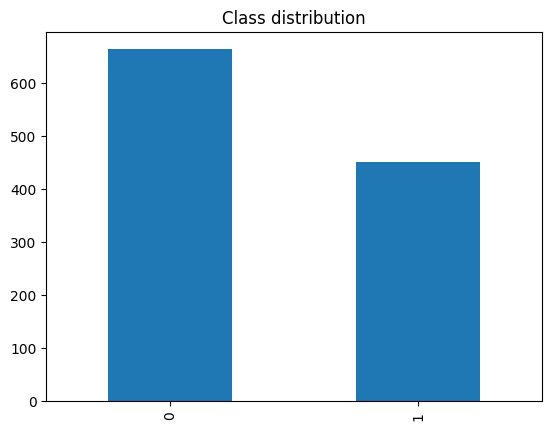

In [3]:
import numpy as np
import pandas as pd

from grakel.datasets import fetch_dataset


dataset = fetch_dataset(
    data_home=".",  # dataset location
    name="PROTEINS",
    with_classes=True,
    as_graphs=True,
)
graphs = dataset.data
y = dataset.target
y = y - 1  # remap {1, 2} to {0, 1}

print(f"Number of classes: {len(np.unique(y))}")
print()
pd.Series(y).value_counts().plot.bar(title="Class distribution")

## Weisfeiler-Lehman kernel classification

1. Calculate kernel matrix for training and test data
2. Classify with kernel SVM

We will use code inspired by [GraKeL MUTAG dataset tutorial](https://ysig.github.io/GraKeL/0.1a8/auto_examples/shortest_path.html).

In [4]:
import numpy as np
from grakel import Graph
from grakel.kernels import WeisfeilerLehman
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC


def train_wl_kernel_svm(graphs: list[Graph], y: np.ndarray) -> None:
    # create kernel
    kernel = WeisfeilerLehman(n_jobs=-1, normalize=True, n_iter=5)

    # create SVM with precomputed kernel
    clf = SVC(kernel="precomputed", random_state=1234)

    # make pipeline
    pipeline = make_pipeline(kernel, clf)

    # testing with 10-fold CV
    scores = cross_val_score(
        estimator=pipeline,
        X=graphs,
        y=y,
        scoring="accuracy",
        cv=10,
    )
    test_acc = np.mean(scores)
    print(f"Test accuracy: {100 * test_acc:.2f}")


In [5]:
train_wl_kernel_svm(graphs, y)

Test accuracy: 75.73
